In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import time
from math import log10, floor
import os
import glob
import matplotlib.pyplot as plt
import datetime
from math import ceil, isnan
import sys
try:
    import torchtext
    from torchtext.data import Field, Iterator, Dataset, Example
except ImportError: 
    !{'/opt/anaconda3/bin/python3'} -m pip install --upgrade git+https://github.com/pytorch/text
    import torchtext
    from torchtext.data import Field, Iterator, Dataset

from relational_rnn_models import RelationalMemoryGenerator
from discriminator import RelGANDiscriminator

cuda = torch.cuda.is_available()

# Try setting the device to a GPU
device = torch.device("cuda:0" if cuda else "cpu")
print('Device:', device)

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

Device: cuda:0


In [2]:
# Helper function(s)

# round a number to n significant digits
def round_to_n(x, n = 2):
    return round(x, -int(floor(log10(abs(x)))) + (n - 1)) if x != 0 else 0

# Transform a date string into a datetime object
def str_to_datetime(string):
    return datetime.datetime.strptime(string, '%Y-%m-%d %H:%M:%S')

# TODO: more complex reduction: takes into account different ICD groups?
def reduce_icd(icd_full):
    return icd_full[:2]

def get_distribution(data, field, vocab_size, fake = True):
    counts = torch.zeros(vocab_size)

    for i in range(vocab_size):
        if fake:
            counts[i] = torch.sum(data == i)
        else:
            counts[i] = field.vocab.freqs[field.vocab.itos[i]]

    freqs = counts / torch.sum(counts)
    
    return counts, freqs
    

In [184]:
%%time

filename = 'data/FINNGEN_ENDPOINTS_DF3_longitudinal_V1_for_SandBox.txt.gz'

events = pd.read_csv(filename, compression = 'infer', sep='\t', nrows = 2_000_000) #

print(events.columns)

subjects = events['FINNGENID'].unique()
n_individuals = len(subjects)
print(n_individuals)

Index(['FINNGENID', 'EVENT_AGE', 'EVENT_YEAR', 'ENDPOINT'], dtype='object')
2049
CPU times: user 1.57 s, sys: 72 ms, total: 1.64 s
Wall time: 1.44 s


In [4]:
%%time

print(events.groupby('FINNGENID').apply(lambda x: x['EVENT_AGE'].max() - x['EVENT_AGE'].min()).describe())
print(events.groupby('FINNGENID').apply(lambda x: len(x)).describe())

count    2049.000000
mean       31.525266
std        10.209654
min         0.000000
25%        22.660000
50%        32.250000
75%        40.460000
max        53.200000
dtype: float64
count     2049.000000
mean       976.085896
std       1599.005733
min          4.000000
25%        166.000000
50%        435.000000
75%       1184.000000
max      31050.000000
dtype: float64
CPU times: user 904 ms, sys: 100 ms, total: 1 s
Wall time: 991 ms


In [5]:
max_sequence_length = 15

sequence_length = min(events.groupby('FINNGENID').apply(lambda x: len(x)).max(), max_sequence_length)
print(sequence_length)

def get_sequence_of_codes(subject):
    codes = []
    
    count = 0
    for i in subject.sort_values('EVENT_AGE').index:
        codes.append(subject.loc[i, 'ENDPOINT'])
        count += 1
        if count == sequence_length:
            break
        
    res = ' '.join(codes)
    return res

def get_sequence_of_time_differences(subject):
    times = [0]
    
    count = 0
    for i in subject.sort_values('EVENT_AGE').index:
        times.append(subject.loc[i, 'EVENT_AGE'])
        count += 1
        if count == sequence_length:
            break
        
    res = np.diff(times)
    return res
    

15


In [6]:
%%time

sequences_of_codes = events.groupby('FINNGENID').apply(get_sequence_of_codes)
#print(sequences_of_codes.head())
print(sequences_of_codes.apply(lambda x: len(x.split(' '))).describe())
print(sequences_of_codes.shape)

sequences_of_times = events.groupby('FINNGENID').apply(get_sequence_of_time_differences)
#print(sequences_of_times.head())
print(sequences_of_times.apply(lambda x: len(x)).describe())
print(sequences_of_times.shape)

count    2049.000000
mean       14.952172
std         0.583511
min         4.000000
25%        15.000000
50%        15.000000
75%        15.000000
max        15.000000
dtype: float64
(2049,)
count    2049.000000
mean       14.952172
std         0.583511
min         4.000000
25%        15.000000
50%        15.000000
75%        15.000000
max        15.000000
dtype: float64
(2049,)
CPU times: user 4.05 s, sys: 76 ms, total: 4.13 s
Wall time: 4.13 s


In [7]:
#sequences = pd.DataFrame({'ENDPOINTS': sequences_of_codes.stack(), 'TIME_DIFFS': sequences_of_times.stack()})
sequences = pd.DataFrame({'ENDPOINTS': sequences_of_codes, 'TIME_DIFFS': sequences_of_times})
print(sequences.shape)
#sequences.head()


(2049, 2)


In [8]:
# https://stackoverflow.com/questions/52602071/dataframe-as-datasource-in-torchtext

class DataFrameDataset(Dataset):
    """Class for using pandas DataFrames as a datasource"""
    def __init__(self, examples, fields, filter_pred=None):
        """
        Create a dataset from a pandas dataframe of examples and Fields
        Arguments:
            examples pd.DataFrame: DataFrame of examples
            fields {str: Field}: The Fields to use in this tuple. The
                string is a field name, and the Field is the associated field.
            filter_pred (callable or None): use only exanples for which
                filter_pred(example) is true, or use all examples if None.
                Default is None
        """
        self.fields = dict(fields)
        self.examples = examples.apply(SeriesExample.fromSeries, args=(self.fields,), axis=1).tolist()
        if filter_pred is not None:
            self.examples = filter(filter_pred, self.examples)
        # Unpack field tuples
        for n, f in list(self.fields.items()):
            if isinstance(n, tuple):
                self.fields.update(zip(n, f))
                del self.fields[n]

class SeriesExample(Example):
    """Class to convert a pandas Series to an Example"""
    
    @classmethod
    def fromSeries(cls, data, fields):
        return cls.fromdict(data.to_dict(), fields)

    @classmethod
    def fromdict(cls, data, fields):
        ex = cls()
        for key, field in fields.items():
            if key not in data:
                raise ValueError("Specified key {} was not found in "
                "the input data".format(key))
            if field is not None:
                setattr(ex, key, field.preprocess(data[key]))
            else:
                setattr(ex, key, data[key])
        return ex

In [9]:
%%time

tokenize = lambda x: x.split(' ')

ENDPOINT = Field(fix_length = sequence_length, tokenize = tokenize)

fields = [('ENDPOINTS', ENDPOINT), ('TIME_DIFFS', None)]

train_sequences, val_sequences = train_test_split(sequences, test_size = 0.1)
print(train_sequences.shape, val_sequences.shape)

train = DataFrameDataset(train_sequences, fields)
val = DataFrameDataset(val_sequences, fields)

ENDPOINT.build_vocab(train, val)

(1844, 2) (205, 2)
CPU times: user 80 ms, sys: 8 ms, total: 88 ms
Wall time: 86.5 ms


In [10]:
print(ENDPOINT.vocab.stoi['ANY_ATC'])
print(ENDPOINT.vocab.itos[2])
vocab_size = len(ENDPOINT.vocab.freqs) + 2
print(vocab_size)

print(ENDPOINT.vocab.freqs[ENDPOINT.vocab.itos[3]])


2
ANY_ATC
887
3674


In [11]:
val_iter = Iterator(val, batch_size = len(val_sequences), repeat = True)

next(iter(val_iter)).ENDPOINTS.transpose(0, 1).shape

torch.Size([205, 15])

In [12]:
subjects = sequences.index
n_individuals = len(subjects)
print(n_individuals)
print(vocab_size / (n_individuals * sequence_length)) # The lower this is the easier it is for the generator to learn

2049
0.028859606312022126


In [13]:
# Test generator output

mem_slots = 4
head_size = 2
embed_size = 2
temperature = 1
num_heads = 2

G = RelationalMemoryGenerator(mem_slots, head_size, embed_size, vocab_size, temperature, num_heads)

start_token = torch.tensor([[0]])
memory = G.initial_state(batch_size = 1)

if cuda:
    G.cuda()
    start_token = start_token.cuda()
    memory = memory.cuda()

print(memory)
logits, tokens, _, memory = G(start_token, memory, sequence_length, None)
print(logits)
print(tokens)
print(memory)


tensor([[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]], device='cuda:0')
tensor([[[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0',
       grad_fn=<CatBackward>)
tensor([[  0, 565, 501, 886, 393, 545, 123, 849, 881, 105, 871, 732, 677, 695,
         780]], device='cuda:0')
tensor([[[ 3.6013, -0.8913,  1.1155,  0.4686],
         [-1.7817,  0.0860,  0.1127,  1.4632],
         [-2.3865, -0.8038,  0.1628,  1.4679],
         [-2.3233, -0.7811,  0.1869,  2.0292]]], device='cuda:0',
       grad_fn=<AddBackward0>)


In [91]:
# Define generator evaluation function

def chi_sqrd_dist(counts1, counts2, separate = False, eps = 1e-20):
    counts1 = counts1.view(1, -1)
    counts2 = counts2.view(1, -1)
    table = torch.cat([counts1, counts2], dim = 0)
    col_sums = torch.sum(table, dim = 0)
    row_sums = torch.sum(table, dim = 1)
    n = torch.sum(col_sums)
    
    table_freq = table / n
    col_freqs = col_sums / n
    row_freqs = row_sums / n
    
    diffs = table_freq[0, :] / (row_freqs[0] + eps) - table_freq[1, :] / (row_freqs[1] + eps)
    diffs_sqrd = diffs ** 2
    diffs_sqrd_norm = diffs_sqrd / (col_freqs + eps)
    
    if separate: 
        return diffs_sqrd_norm
    
    chi_sqrd_distance = torch.sum(diffs_sqrd_norm)
    
    return chi_sqrd_distance

def get_fake_distribution(G, start_tokens, vocab_size = vocab_size, sequence_length = sequence_length):
    memory = G.initial_state(batch_size = start_tokens.shape[0])

    if cuda:
        memory = memory.cuda()
        start_tokens = start_tokens.cuda()
    
    _, data_fake, _, _ = G(start_tokens, memory, sequence_length)
    
    counts_fake, freqs_fake = get_distribution(data_fake, None, vocab_size, fake = True)
    
    return counts_fake, freqs_fake
    
def get_score(G, ENDPOINT, start_tokens, vocab_size = vocab_size, sequence_length = sequence_length):
    counts_real, freqs_real = get_distribution(None, ENDPOINT, vocab_size, fake = False)
    
    counts_fake, freqs_fake = get_fake_distribution(G, start_tokens, vocab_size, sequence_length)
    
    score = chi_sqrd_dist(counts_real, counts_fake)
    return score

val_data = next(iter(val_iter)).ENDPOINTS.transpose(0, 1)

score = get_score(G, ENDPOINT, val_data[:, :1])
print(score)

tensor(1.4624)


In [15]:
# Test Discriminator output

n_embeddings = 2
embed_size = 2
out_channels = 5 
filter_sizes = [2, 3] # values can be at most the sequence_length

D = RelGANDiscriminator(n_embeddings, vocab_size, embed_size, sequence_length, out_channels, filter_sizes)

if cuda:
    D.cuda()

inp = logits
print(inp)
print(D(inp, False))
print(D(inp))


tensor([[[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0',
       grad_fn=<CatBackward>)
tensor([[0.5753, 0.5753]], device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor([0.5753], device='cuda:0', grad_fn=<MeanBackward2>)


In [68]:
# Define the generator pre-train function

def pretrain_generator(G, train, batch_size, vocab_size, sequence_length, n_epochs, lr, print_step = 10):
    loss_function = nn.BCELoss()
    optimizer = torch.optim.Adam(G.parameters(), lr=lr)
    
    if cuda:
        G.cuda()
        loss_function.cuda()
    
    for e in range(n_epochs):
        train_iter = Iterator(train, batch_size = batch_size, device = device)
        loss_total = 0
        count = 0
        
        for batch in train_iter:
            train_data = batch.ENDPOINTS.transpose(0, 1)
            train_data_one_hot = F.one_hot(train_data, vocab_size).type(Tensor)
            
            start_token = train_data[:, :1]
            optimizer.zero_grad()

            memory = G.initial_state(batch_size = train_data.shape[0])

            if cuda:
                start_token = start_token.cuda()
                memory = memory.cuda()
                
            logits, _, _, _ = G(start_token, memory, sequence_length, 1.0)

            loss = loss_function(logits, train_data_one_hot)
            
            loss_total += loss.item()
            count += 1

            loss.backward()
            optimizer.step()
            
        
        if e % print_step == 0:
            print(
                "[Epoch %d/%d] [G loss: %f]"
                % (e, n_epochs, loss_total / count)
            )

In [69]:
mem_slots = 4
head_size = 2
embed_size = 2
temperature = 1
num_heads = 2

G = RelationalMemoryGenerator(mem_slots, head_size, embed_size, vocab_size, temperature, num_heads)

if cuda:
    G.cuda()
    
val_data = next(iter(val_iter)).ENDPOINTS.transpose(0, 1)

score = get_score(G, ENDPOINT, val_data[:, :1])
print(score)

batch_size = 64
pretrain_generator(G, train, batch_size, vocab_size, sequence_length, 3, 0.01, print_step = 1)

score = get_score(G, ENDPOINT, val_data[:, :1])
print(score)

tensor(5.4272)
[Epoch 0/1] [G loss: 0.058049]
tensor(5.0311)


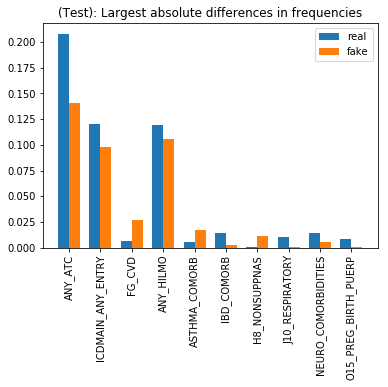

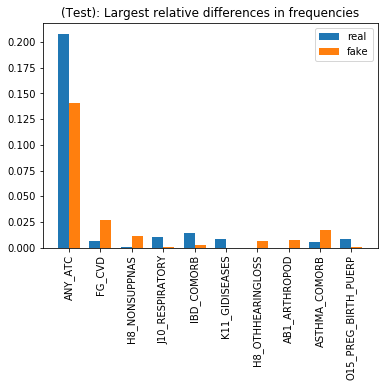

In [185]:
def save_grouped_barplot(freqs, freqs_fake, idx, title, N=10):
    freqs1 = freqs.numpy()[idx]
    freqs2 = freqs_fake.numpy()[idx]

    fig, ax = plt.subplots(figsize=(6,6))

    ind = np.arange(N)    # the x locations for the groups
    width = 0.35         # the width of the bars
    p1 = ax.bar(ind, freqs1, width, bottom=0)

    p2 = ax.bar(ind + width, freqs2, width, bottom=0)

    ax.set_title(title)
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(map(lambda x: ENDPOINT.vocab.itos[x], idx), rotation=90)

    ax.legend((p1[0], p2[0]), ('real', 'fake'))
    ax.autoscale_view()
    
    fig.subplots_adjust(bottom=0.36)
    fig.savefig('figs/' + '_'.join(title.split(' ')).translate({ord(i): None for i in ':()'}) + '.svg')
    
def save_relative_and_absolute(freqs, freqs_fake, counts, counts_fake, prefix='', N=10):
    if not prefix == '':
        prefix += ' '
    abs_diffs = np.abs(freqs - freqs_fake)
    idx = np.argsort(abs_diffs)[-N:]
    idx = np.flip(idx)

    title = prefix + 'Largest absolute differences in frequencies'
    save_grouped_barplot(freqs, freqs_fake, idx, title, N)
    
    chi_sqrd_dists = chi_sqrd_dist(counts, counts_fake, separate = True)
    idx = np.argsort(chi_sqrd_dists)[-N:]
    idx = np.flip(idx)

    title = prefix + 'Largest relative differences in frequencies'
    save_grouped_barplot(freqs, freqs_fake, idx, title, N)
    

train_iter = Iterator(train, batch_size = len(train_sequences))
train_data = next(iter(train_iter)).ENDPOINTS.transpose(0, 1)
    
counts, freqs = get_distribution(None, ENDPOINT, vocab_size, fake = False)
counts_fake1, _ = get_fake_distribution(G, val_data[:, :1])
counts_fake2, _ = get_fake_distribution(G, train_data[:, :1])

counts_fake = counts_fake1 + counts_fake2
freqs_fake = counts_fake / torch.sum(counts_fake)

N = 10
prefix = '(Test):'

save_relative_and_absolute(freqs, freqs_fake, counts, counts_fake, prefix, N)

In [70]:
# Define the training function

def train_GAN(G, D, train, val_iter, batch_size, vocab_size, sequence_length, \
              n_epochs, lr, temperature, print_step = 10, score_fn = get_score):    
    scores = []
    
    val_data = next(iter(val_iter)).ENDPOINTS.transpose(0, 1)
    
    score = score_fn(G, ENDPOINT, val_data[:, :1])
    print('Score before training:', score)
    scores.append(torch.tensor(score))
    
    print('pretraining generator...')
    pretrain_generator(G, train, batch_size, vocab_size, sequence_length, max(n_epochs // 10, 1), \
                       lr * 100, print_step = max(n_epochs // 10 - 1, 1))
    print('pretraining complete')
    
    score = score_fn(G, ENDPOINT, val_data[:, :1])
    print("[Score:", score, "]")
    scores.append(torch.tensor(score))
    
    adversarial_loss = torch.nn.BCELoss()
    
    optimizer_G = torch.optim.Adam(G.parameters(), lr=lr)
    optimizer_D = torch.optim.Adam(D.parameters(), lr=lr)
    
    if cuda:
        G.cuda()
        D.cuda()
        adversarial_loss.cuda()
    
    for e in range(n_epochs):
        train_iter = Iterator(train, batch_size = batch_size, device = device)
        #loss_total = 0
        #count = 0
        
        for batch in train_iter:
            train_data = batch.ENDPOINTS.transpose(0, 1)
            train_data_one_hot = F.one_hot(train_data, vocab_size).type(Tensor)

            start_token = train_data[:, :1]
            
            # Adversarial ground truths
            valid = Variable(Tensor(train_data.shape[0], 1).fill_(1.0), requires_grad=False)
            fake = Variable(Tensor(train_data.shape[0], 1).fill_(0.0), requires_grad=False)

            optimizer_G.zero_grad()

            # Generate a batch of images
            memory = G.initial_state(batch_size = train_data.shape[0])
            if cuda:
                memory = memory.cuda()

            temp = temperature ** ((e + 1) / n_epochs)
            fake_one_hot, _, _, _ = G(start_token, memory, sequence_length, temp)

            # Loss measures generator's ability to fool the discriminator
            g_loss = adversarial_loss(D(fake_one_hot), valid)

            g_loss.backward()
            optimizer_G.step()

            optimizer_D.zero_grad()

            # Measure discriminator's ability to classify real from generated samples
            real_loss = adversarial_loss(D(train_data_one_hot).view(-1), valid.view(-1))
            fake_loss = adversarial_loss(D(fake_one_hot.detach()).view(-1), fake.view(-1))
            d_loss = (real_loss + fake_loss) / 2

            d_loss.backward()
            optimizer_D.step()

        if e % print_step == 0:
            print(
                "[Epoch %d/%d] [D loss: %f] [G loss: %f]"
                % (e, n_epochs, d_loss.item(), g_loss.item())
            )
            score = score_fn(G, ENDPOINT, val_data[:, :1])
            print("[Score:", score, "]")
            scores.append(torch.tensor(score))
            
    score = score_fn(G, ENDPOINT, val_data[:, :1])
    print('Score after training:', score)
    scores.append(torch.tensor(score))
            
    # return scores
    return torch.stack(scores)


Score before training: tensor(4.9515)
pretraining generator...


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


[Epoch 0/10] [G loss: 0.058068]
[Epoch 9/10] [G loss: 0.057215]
pretraining complete
[Score: tensor(4.1897) ]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch 0/100] [D loss: 0.694506] [G loss: 0.743430]
[Score: tensor(4.1713) ]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch 10/100] [D loss: 0.666941] [G loss: 0.671437]
[Score: tensor(1.8781) ]
[Epoch 20/100] [D loss: 0.660227] [G loss: 0.731474]
[Score: tensor(6.1385) ]
[Epoch 30/100] [D loss: 0.444049] [G loss: 0.888282]
[Score: tensor(1.9894) ]
[Epoch 40/100] [D loss: 0.403967] [G loss: 1.092172]
[Score: tensor(6.6486) ]
[Epoch 50/100] [D loss: 0.436609] [G loss: 1.208424]
[Score: tensor(2.6073) ]
[Epoch 60/100] [D loss: 0.316437] [G loss: 1.670107]
[Score: tensor(3.0804) ]
[Epoch 70/100] [D loss: 0.393549] [G loss: 1.471346]
[Score: tensor(2.6416) ]
[Epoch 80/100] [D loss: 0.307160] [G loss: 1.800984]
[Score: tensor(1.9240) ]
[Epoch 90/100] [D loss: 0.259974] [G loss: 1.964565]
[Score: tensor(2.5553) ]
Score after training: tensor(2.5745)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Time taken: 1040.0 seconds


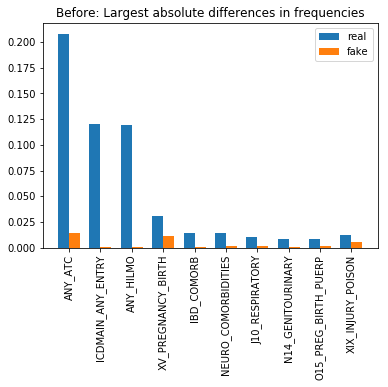

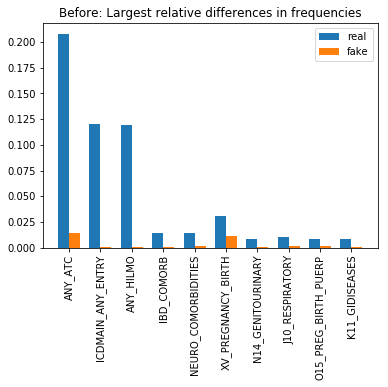

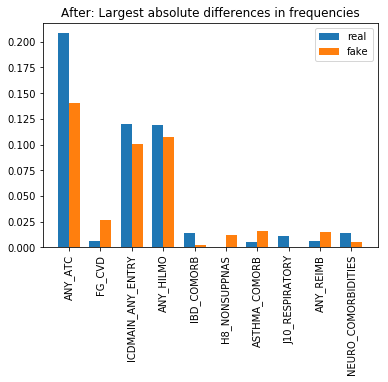

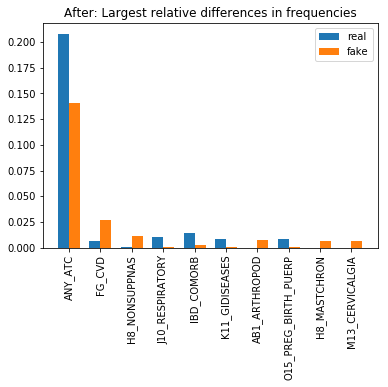

In [181]:
# Train the GAN

start_time = time.time()

# Generator params
mem_slots = 1
head_size = 6
embed_size = 10
temperature = 50
num_heads = 10
num_blocks = 6

G = RelationalMemoryGenerator(mem_slots, head_size, embed_size, vocab_size, temperature, num_heads, num_blocks)

# Discriminator params
n_embeddings = 5
embed_size = embed_size
out_channels = 15
filter_sizes = [2, 3, 4] # values can be at most the sequence_length

D = RelGANDiscriminator(n_embeddings, vocab_size, embed_size, sequence_length, out_channels, filter_sizes)

if cuda:
    G.cuda()
    D.cuda()

counts_fake1, _ = get_fake_distribution(G, val_data[:, :1])
counts_fake2, _ = get_fake_distribution(G, train_data[:, :1])

counts_fake = counts_fake1 + counts_fake2
freqs_fake = counts_fake / torch.sum(counts_fake)

N = 10
prefix = 'Before:'

save_relative_and_absolute(freqs, freqs_fake, counts, counts_fake, prefix, N)



batch_size = 64
n_epochs = 100
print_step = n_epochs // 10
lr = 1e-4

# Train the GAN
scores = train_GAN(G, D, train, val_iter, batch_size, vocab_size, sequence_length, n_epochs, lr, temperature, print_step)



counts_fake1, _ = get_fake_distribution(G, val_data[:, :1])
counts_fake2, _ = get_fake_distribution(G, train_data[:, :1])

counts_fake = counts_fake1 + counts_fake2
freqs_fake = counts_fake / torch.sum(counts_fake)

prefix = 'After:'

save_relative_and_absolute(freqs, freqs_fake, counts, counts_fake, prefix, N)

print('Time taken:', round_to_n(time.time() - start_time, n = 3), 'seconds')


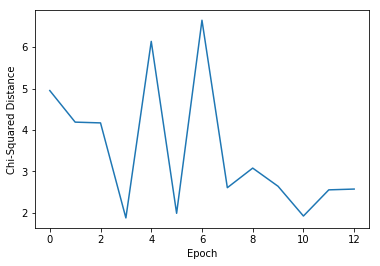

In [182]:
%matplotlib inline

plt.plot(range(scores.shape[0]), scores.numpy())
plt.ylabel('Chi-Squared Distance')
plt.xlabel('Epoch')
plt.savefig('figs/chisqrd.svg')